# Higher-order (HO) approximation on dome-shaped ice sheet

FOR TOMORROW: 

Write ```prognostic_solve``` and ```coupled_solve```
## Imports

In [1]:
########################
### "normal" imports ###
########################

import numpy as np
import matplotlib.pyplot as plt

######################
### ISSM functions ###
######################

from model import model
from setflowequation import setflowequation
from solve import solve
from squaremesh import squaremesh
from bamg import bamg

## Initialize model and mesh domain

We will mesh the domain as a square, then later define the ice sheet to have a circular footprint within that square. 

In [2]:
len_x, len_y = 100e3, 100e3
nx, ny = 25, 25
Δx, Δy = int(len_x/nx), int(len_y/ny)

md = model()
md = squaremesh(md, len_x, len_y, nx, ny) 

## Define circular footprint and refine mesh

Refine so that we have higher mesh density near the periphery of the ice sheet, then apply ice and ocean levelsets.  

In [3]:
#####################
### circle params ###
#####################

x, y = md.mesh.x, md.mesh.y
x_0, y_0 = np.mean(x), np.mean(y) #the centre of the mesh is at (x_0, y_0)
r = min(x_0, y_0)   #ensure the circular footprint stays within the meshed area
d = np.sqrt((x - x_0)**2 + (y - y_0)**2)

#######################
### refine the mesh ###
#######################

length_scale = x.max()/100
size_min, size_max = min(Δx, Δy)/10, max(Δx, Δy)
refinement_function = np.exp(-((r - d)/length_scale)**2)
md = bamg(md, 'field', refinement_function, 'err', 5e-3, 'hmin', size_min, 'hmax', size_max)

##########################################
### reinitialize mesh-dependent params ###
##########################################

x, y = md.mesh.x, md.mesh.y
elts = md.mesh.elements - 1
d = np.sqrt((x - x_0)**2 + (y - y_0)**2)

############################
### initialize levelsets ###
############################

md.mask.ice_levelset = d**2 - r**2 #negative within the footprint, positive outside, zero at circular boundary
md.mask.ocean_levelset = np.ones_like(x)   #pos = grounded, neg = floating, 0 = GL

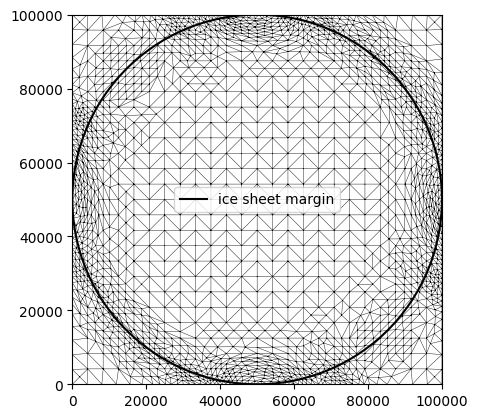

In [4]:
plt.triplot(x, y, elts, linewidth = 0.3, color = 'k')
plt.tricontour(x, y, elts, md.mask.ice_levelset, levels = [0], colors = 'k')
plt.plot([], [], 'k', label = 'ice sheet margin')   # dummy legend handle
plt.legend()
plt.gca().set_aspect('equal')

In [5]:
############################
### geometric parameters ###
############################

H_max = 1000
H = H_max/r*np.sqrt(np.maximum(0, r**2 - d**2))

##############
### solver ###
##############

md = setflowequation(md, 'HO', 'all') #apply the HO approximation over the entire domain

## Make ISSM like icepack

In [6]:
from project3d import project3d

############################
############################
### model initialization ###
############################
############################

def initialize_model(md, **kwargs):
    
    T = kwargs.get('temperature', 273.15)
    C = kwargs.get('friction', 0)
    p = kwargs.get('p', 1)
    q = kwargs.get('q', 1)
    u = kwargs.get('velocity', None)
    H_in = kwargs.get('thickness_inflow', None)
    Γ_x = kwargs.get('dirichlet_x', np.zeros(md.mesh.numberofvertices).astype(bool))
    Γ_y = kwargs.get('dirichlet_y', np.zeros(md.mesh.numberofvertices).astype(bool))
    Γ_in = kwargs.get('inflow_boundary', np.zeros(md.mesh.numberofvertices).astype(bool))
    name = kwargs.get('name', 'name')
    vertical_layers = kwargs.get('vertical_layers', 5)
    extrusion_exponent = kwargs.get('extrusion_exponent', 1)

    num_e = md.mesh.numberofelements
    num_v = md.mesh.numberofvertices

    ###############
    ### storage ###
    ###############

    md.miscellaneous.temperature = T
    md.miscellaneous.name = name
    md.miscellaneous.friction = C
    md.miscellaneous.friction_p = p
    md.miscellaneous.friction_q = q
    md.miscellaneous.vertical_layers = vertical_layers if md.flowequation.isHO else np.nan
    md.miscellaneous.extrusion_exponent = extrusion_exponent if md.flowequation.isHO else np.nan

    ################
    ### rheology ###
    ################
    
    T_t = 263.15 #transition temperature (K)
    Q = 6e4 if T < T_t else 115e3 #activation enegy (J/mol), depends on temperature
    A_0 = 3.5e-25 #rate prefactor (s^-1 Pa^-3)
    R = 8.314 #gas constant (J mol^-1 K^-1)
    A_val = A_0*np.exp(-Q/R*(1/T - 1/T_t)) #final rate factor (s^-1 Pa^-3)
    B_val = A_val**(-1/md.materials.rheology_n)
    md.materials.rheology_B = B_val*np.ones(num_v)
    md.miscellaneous.rheology_A = A_val

    ################
    ### friction ###
    ################

    md.friction.coefficient = C*np.ones(num_v) if np.isscalar(C) else C
    md.friction.p = p*np.ones(num_e) if np.isscalar(p) else p
    md.friction.q = q*np.ones(num_e) if np.isscalar(q) else q

    ###############################
    ### set boundary conditions ###
    ###############################

    Γ_x = np.array(Γ_x).astype(bool)
    Γ_y = np.array(Γ_y).astype(bool)
    Γ_z = np.zeros_like(Γ_x).astype(bool)
    md.stressbalance.spcvx = np.nan*np.ones(num_v)
    md.stressbalance.spcvy = np.nan*np.ones(num_v)
    md.stressbalance.spcvz = np.nan*np.ones(num_v)
    md.masstransport.spcthickness = np.nan*np.ones(num_v)

    if u is None:
        if True in Γ_x | Γ_y | Γ_z:
            print('Must provide initial velocity to enforce Dirichlet BCs')
    else: 
        md.stressbalance.spcvx[Γ_x] = u[0] if np.isscalar(u[0]) else u[0][Γ_x]
        md.stressbalance.spcvy[Γ_y] = u[1] if np.isscalar(u[1]) else u[1][Γ_y]

    Γ_in = np.array(Γ_in).astype(bool)

    if H_in is None:
        if True in Γ_in:
            print('Must provide thickness inflow to enforce Dirichlet BC')
    else:
        md.masstransport.spcthickness[Γ_in] = H_in if np.isscalar(H_in) else H_in[Γ_in]

    ##############
    ### extras ###
    ##############

    md.stressbalance.referential = np.nan*np.ones((num_v, 6))
    md.stressbalance.loadingforce = np.zeros((num_v, 3))
    md.basalforcings.groundedice_melting_rate = np.zeros(num_v)
    md.basalforcings.floatingice_melting_rate = np.zeros(num_v)
    md.geometry.thickness = np.ones(num_v)
    md.geometry.surface = np.ones(num_v)
    md.geometry.base = np.zeros(num_v)
    md.smb.initialize(md) #initialize an empty SMB field


    ############################
    ### extrude if necessary ###
    ############################

    if md.flowequation.isHO and not hasattr(md.mesh, 'numberofvertices2d'): 
        md.miscellaneous.mesh2d = md.mesh
        md = md.extrude(vertical_layers, extrusion_exponent, 1)
        md.miscellaneous.zeta = md.mesh.z #this will tell us how z is distributed proportionally

########################
########################
### diagnostic solve ###
########################
########################

def diagnostic_solve(md, **kwargs):
    H = kwargs['thickness']
    s = kwargs.get('surface', None)
    b = kwargs.get('base', None)

    ρ_i = md.materials.rho_ice
    ρ_w = md.materials.rho_water
    ϱ = ρ_i/ρ_w

    ####################
    ### set geometry ###
    ####################

    if s is None and b is not None:
        s = H + b
    elif b is None and s is not None:
        b = s - H
    elif s is None and b is None:
        s = (1 - ϱ)*H if md.flowequation.isSSA else H
        b = s - H
        print('Warning: assumed surface and basal elevations')

    if np.size(H) == md.miscellaneous.mesh2d.numberofvertices and np.size(H) != md.mesh.numberofvertices:
        H = project3d(md, 'vector', H, 'type', 'node')
        s = project3d(md, 'vector', s, 'type', 'node')
        b = project3d(md, 'vector', b, 'type', 'node')

    md.geometry.thickness = H
    md.geometry.surface = s
    md.geometry.base = b

    #####################
    ### update mesh.z ###
    #####################

    if md.flowequation.isHO:
        ζ = md.miscellaneous.zeta
        md.mesh.z = b + ζ*H

    ############
    ### misc ###
    ############

    md.timestepping.time_step = 1 #try to model only a single mass-transport step
    md.timestepping.final_time = 1
    md.transient.isstressbalance = 1 #solve the stress balance?
    md.transient.ismasstransport = 0 #solve mass transport?
    md.transient.isthermal = 0 #don't bother with heat transport

    md = solve(md, 'Stressbalance')
    solution = md.results.StressbalanceSolution
    u_x, u_y = solution.Vx.flatten(), solution.Vy.flatten()
    u = (u_x, u_y)
    if md.flowequation.isHO:
        u = (u_x, u_y, solution.Vz.flatten())
    return u          

## Get the instantaneous solution (no timestepping)

In [7]:
initialize_model(md, friction = 10000)

      no smb.mass_balance specified: values set as zero


In [8]:
u_x, u_y, u_z = diagnostic_solve(md, thickness = H)

checking model consistency
marshalling file 'name'.bin
uploading input file and queuing script
launching solution sequence on remote cluster

──────────────────────────────────────────────────────────────────────
Ice-sheet and Sea-level System Model (ISSM) version 2026.1
          GitHub: https://github.com/ISSMteam/ISSM/
   Documentation: https://issmteam.github.io/ISSM-Documentation/
──────────────────────────────────────────────────────────────────────
call computational core:
   computing new velocity
   computing basal mass balance
   computing vertical velocities
write lock file:

   FemModel initialization elapsed time:   0.246177
   Total Core solution elapsed time:       20.6511
   Linear solver elapsed time:             11.8065 (57%)

   Total elapsed time: 0 hrs 0 min 20 sec
loading results from cluster


## Plot results

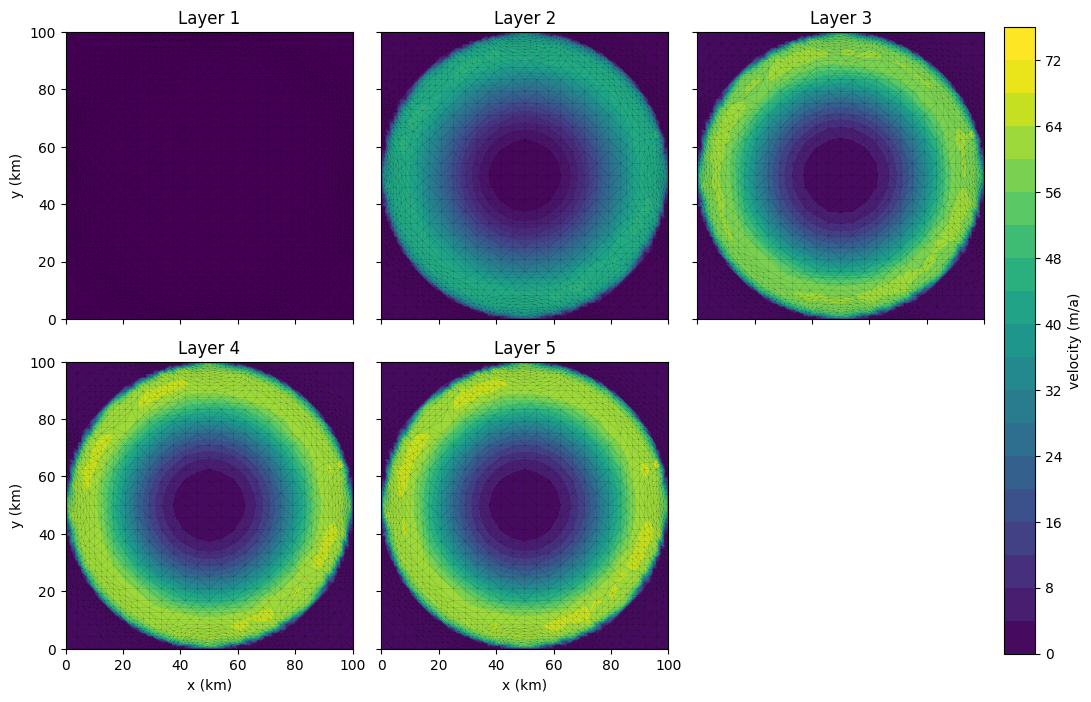

In [9]:
from matplotlib.ticker import FuncFormatter

num_layers = md.mesh.numberoflayers
num_nodes_surface = md.mesh.numberofvertices2d
triangles_surface = md.mesh.elements2d - 1
speed3d = np.hypot(u_x, u_y)
# speed3d = md.results.TransientSolution[0].Vel.flatten()

cols = int(np.ceil(num_layers**0.5))
rows = int(np.ceil(num_layers/cols))

fig, axes = plt.subplots(rows, cols, figsize = (4*cols, 4*rows), sharex = 'col', sharey = 'row',
                         gridspec_kw = {'wspace': 0.1, 'hspace': -0.1})
axes = np.atleast_1d(axes).ravel()

km = FuncFormatter(lambda v, _: f'{v/1000:.0f}')
vmax = speed3d.max()

for layer, ax in enumerate(axes):
    if layer >= num_layers: ax.axis('off'); continue
    node_slice = slice(layer*num_nodes_surface, (layer + 1)*num_nodes_surface)

    contour = ax.tricontourf(md.mesh.x[node_slice], md.mesh.y[node_slice], triangles_surface, speed3d[node_slice],
                             levels = 20, vmin = 0, vmax = vmax)

    ax.triplot(md.mesh.x[node_slice], md.mesh.y[node_slice], triangles_surface, color = 'k', linewidth = 0.15, alpha = 0.4)

    ax.set(title = f'Layer {layer + 1}', aspect = 'equal')
    ax.xaxis.set_major_formatter(km); ax.yaxis.set_major_formatter(km)

for ax in axes[-cols:]: ax.set_xlabel('x (km)')
for ax in axes[::cols]: ax.set_ylabel('y (km)')

fig.subplots_adjust(left = 0.07, right = 0.88, bottom = 0.08, top = 0.95)
fig.colorbar(contour, ax = axes[:num_layers], fraction = 0.035, pad = 0.02, shrink = 0.9).set_label('velocity (m/a)')

plt.show()


## Compare numerical HO results with semi-analytic SIA solution

In [10]:
H_nonzero = H.copy()
H_nonzero[H <= 0] = np.nan
thick_grad = (H_max/r)**2*d/H_nonzero #analytic thickness gradient 
n = md.materials.rheology_n
u_SIA = (2*md.miscellaneous.rheology_A/(n + 1))*(917*9.81*thick_grad)**n*H_nonzero**(n + 1) #analytic surface velocity
u_SIA *= 60*60*24*365.25 #into m/a
u_SIA[np.isnan(u_SIA)] = 0. #eliminate nans

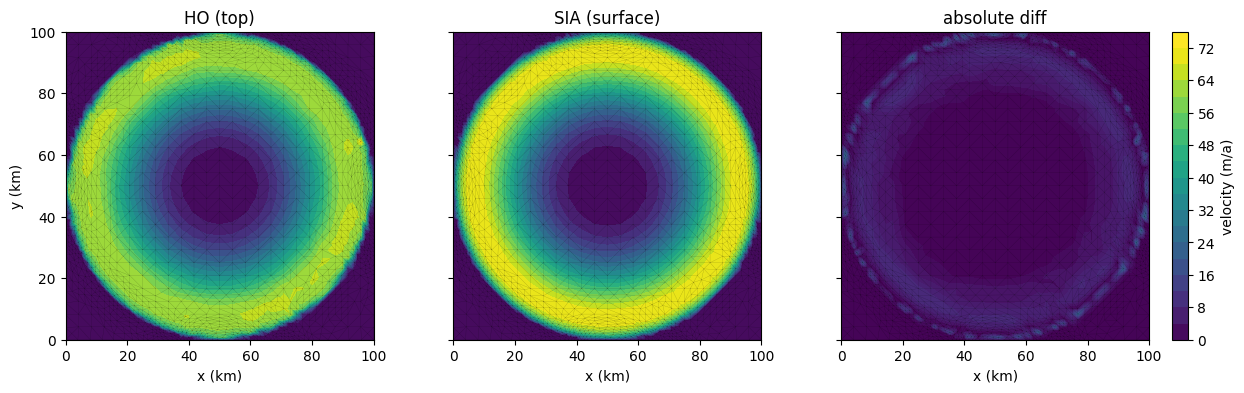

In [11]:
from matplotlib.ticker import FuncFormatter

top = slice((num_layers - 1)*num_nodes_surface, num_layers*num_nodes_surface)
u_HO_top = speed3d[top]
u_diff = np.abs(u_HO_top - u_SIA)

vmax = max(u_HO_top.max(), u_SIA.max(), u_diff.max())

km = FuncFormatter(lambda v, _: f'{v/1000:.0f}')

x2 = getattr(md.mesh, 'x2d', md.mesh.x[:num_nodes_surface])
y2 = getattr(md.mesh, 'y2d', md.mesh.y[:num_nodes_surface])

fig, ax = plt.subplots(1, 3, figsize = (15, 4), sharex = True, sharey = True)

p0 = ax[0].tricontourf(x2, y2, triangles_surface, u_HO_top, levels = 20, vmin = 0, vmax = vmax)
p1 = ax[1].tricontourf(x2, y2, triangles_surface, u_SIA,   levels = 20, vmin = 0, vmax = vmax)
p2 = ax[2].tricontourf(x2, y2, triangles_surface, u_diff,  levels = 20, vmin = 0, vmax = vmax)

for a in ax:
    a.triplot(x2, y2, triangles_surface, color = 'k', linewidth = 0.15, alpha = 0.4)
    a.set(aspect = 'equal')
    a.xaxis.set_major_formatter(km)
    a.yaxis.set_major_formatter(km)

ax[0].set(title = 'HO (top)', xlabel = 'x (km)', ylabel = 'y (km)')
ax[1].set(title = 'SIA (surface)', xlabel = 'x (km)')
ax[2].set(title = 'absolute diff', xlabel = 'x (km)')

fig.colorbar(p0, ax = ax, fraction = 0.035, pad = 0.02).set_label('velocity (m/a)')

plt.show()